# TaRGET Project CC RNA-seq Data Inspection

__Author:__ Bryan Quach  
__Date:__ March 6, 2017

## Objective

### Estimated Analysis Time: <1 day*

Gene expression profiles are expected to be more similar within tissues than across tissues. Using single-end RNA-seq data from the TaRGET project Collaborative Cross (CC) mice, we set out to evaluate this assumption. If we apply PCA and cluster analyis to the data, we hypothesize that gene expression profiles for samples from the same tissue will group together. Our objective is to test this hypothesis as well as visually assess how notable the batch effects are between data that were sequenced by different sequencing centers. Most of our data were sequenced by the UNC High-Throughput Sequencing Facility (HTSF), but we have 20 samples that were sequenced by the center at Texas A&M University (TAMU).

**This estimate optimistically assumes that the analysis will be done as shown below without interruption, with an internet connection with high speed data transfer rates, and with all necessary software already installed. Limitations in internet data transfer rates and software installation can significantly increase analysis time.*

## Analysis Outline

The analysis can be roughly divided into the following steps:

* Data retrieval and wrangling
* Count matrix generation and normalization
* Exploratory Data Analysis (PCA & Clustering)
* Sample mislabeling correction

## R Packages

In addition to the base packages, we use the following R packages in this analysis:

* [DESeq2](http://www.bioconductor.org/packages/release/bioc/html/DESeq2.html)
* [tximport](http://bioconductor.org/packages/release/bioc/html/tximport.html)
* [dbscan](https://cran.r-project.org/web/packages/dbscan/index.html)

## Data retrieval and wrangling

The data we are working with is 76 base pair single-end sequencing reads that have been aligned to CC strain specific pseudo-transcriptomes. These were input into RSEM to quantify gene expression levels. Because the data were sequenced by two different sequencing centers, the naming conventions for files differ. Some samples were re-sequenced, so attention must be paid to ensuring that the original data for these samples is differentiated from the re-sequenced sample data when applying bulk processing commands. Throughout this analysis document, I will use the following terminology to refer to the samples:

* __Unique HTSF samples__: Samples sequenced only by HTSF. These were samples that we deemed from previous analyses to not be problematic in terms of sequencing depth or potential mislabeleing.
* __Non-unique HTSF samples__: Samples that were intially sequenced by HTSF but were then resequenced at TAMU, so two sets of data exist for these samples (one from HTSF and another from TAMU). "Non-unique HTSF" refers to the former set of samples.
* __TAMU samples__: Samples that were intially sequenced by HTSF but were then resequenced at TAMU, so two sets of data exist for these samples (one from HTSF and another from TAMU). "TAMU" refers to the latter set of samples.

We will be doing analyses that incorporate all the data (data from both the original sequencing and re-sequencing), as well as samples that remove the original sequencing results where re-sequencing results are available. For this reason, any samples that data from both HTSF and TAMU will have that data organized into subdirectories.

In [1]:
#Create data directories and retrieve all gene expression quantification files
system("mkdir data")
system("mkdir data/htsf") #HTSF subdirectory
system("mkdir data/tamu") #TAMU subdirectory
system("scp kure.unc.edu:/proj/fureylab/data/RNA-seq/mouse/CC/CC*/*/*genes.results data/")

In [2]:
#Move old files if they have corresponding newer files from re-sequencing
htsf.cmds <- c(
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC053/CC053_BD1500_LUNG_RNA_133/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC036/CC036_BD1500_LUNG_RNA_50/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC001/CC001_BD625_LUNG_RNA_40/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC037/CC037_BD1500_LUNG_RNA_65/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC027/CC027_BD1500_LUNG_RNA_57/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC012/CC012_BD625_LUNG_RNA_33/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC031/CC031_BD625_LUNG_RNA_37/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC025/CC025_BD625_LUNG_RNA_117/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC037/CC037_Control_LUNG_RNA_19/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC051/CC051_BD1500_LUNG_RNA_72/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC035/CC035_BD625_LUNG_RNA_32/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC021/CC021_Control_LUNG_RNA_76/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC053/CC053_Control_LUNG_RNA_75/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC016/CC016_BD625_LUNG_RNA_119/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC028/CC028_BD625_LIVER_RNA_34/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC061/CC061_Control_KIDNEY_RNA_90/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC039/CC039_BD625_KIDNEY_RNA_41/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC033/CC033_BD625_KIDNEY_RNA_120/[KID,LIV,LUNG]*genes.results) data/htsf/",
    "mv data/$(ssh kure.unc.edu basename /proj/fureylab/data/RNA-seq/mouse/CC/CC038/CC038_BD625_KIDNEY_RNA_123/[KID,LIV,LUNG]*genes.results) data/htsf/")

for(cmd in htsf.cmds){ system(cmd) }


#Rename TAMU-related files and move them to a subdirectory
move.cmds <- c(
    "mv data/Rusyn-Lung-133.genes.results data/tamu/LUNG_CC133-BD_study_1500ppm_LUNG_CC_133.genes.results",
    "mv data/Rusyn-Lung-50.genes.results data/tamu/LUNG_CC50-BD_study_1500ppm_LUNG_CC_50.genes.results",
    "mv data/Rusyn-Lung-40.genes.results data/tamu/LUNG_CC40-BD_study_625ppm_LUNG_CC_40.genes.results",
    "mv data/Rusyn-Lung-65.genes.results data/tamu/LUNG_CC65-BD_study_1500ppm_LUNG_CC_65.genes.results",
    "mv data/Rusyn-Lung-57.genes.results data/tamu/LUNG_CC57-BD_study_1500ppm_LUNG_CC_57.genes.results",
    "mv data/Rusyn-Lung-33.genes.results data/tamu/LUNG_CC33-BD_study_625ppm_LUNG_CC_33.genes.results",
    "mv data/Rusyn-Lung-37.genes.results data/tamu/LUNG_CC37-BD_study_625ppm_LUNG_CC_37.genes.results",
    "mv data/Rusyn-Lung-117.genes.results data/tamu/LUNG_CC117-BD_study_625ppm_LUNG_CC_117.genes.results",
    "mv data/Rusyn-Lung-19.genes.results data/tamu/LUNG_CC19-BD_study_0ppm_LUNG_CC_19.genes.results",
    "mv data/Rusyn-Lung-72.genes.results data/tamu/LUNG_CC72-BD_study_1500ppm_LUNG_CC_72.genes.results",
    "mv data/Rusyn-Lung-32.genes.results data/tamu/LUNG_CC32-BD_study_625ppm_LUNG_CC_32.genes.results",
    "mv data/Rusyn-Lung-76.genes.results data/tamu/LUNG_CC76-BD_study_0ppm_LUNG_CC_76.genes.results",
    "mv data/Rusyn-Lung-75.genes.results data/tamu/LUNG_CC75-BD_study_0ppm_LUNG_CC_75.genes.results",
    "mv data/Rusyn-Lung-119.genes.results data/tamu/LUNG_CC119-BD_study_625ppm_LUNG_CC_119.genes.results",
    "mv data/Rusyn-Liver-34.genes.results data/tamu/LIVER_CC34-BD_study_625ppm_LIVER_CC_34.genes.results",
    "mv data/Rusyn-Kidney-90.genes.results data/tamu/KIDNEY_CC90-BD_study_0ppm_KIDNEY_CC_90.genes.results",
    "mv data/Rusyn-Kidney-41.genes.results data/tamu/KIDNEY_CC41-BD_study_625ppm_KIDNEY_CC_41.genes.results",
    "mv data/Rusyn-Kidney-120.genes.results data/tamu/KIDNEY_CC120-BD_study_625ppm_KIDNEY_CC_120.genes.results",
    "mv data/Rusyn-Kidney-124.genes.results data/tamu/KIDNEY_CC124-BD_study_625ppm_KIDNEY_CC_124.genes.results",
    "mv data/Rusyn-Kidney-123.genes.results data/tamu/KIDNEY_CC123-BD_study_625ppm_KIDNEY_CC_123.genes.results")

for(cmd in move.cmds){ system(cmd) }

#Rename all files to be more concise
files <- list.files("data/", pattern="genes.results")
for(file in files){
    name.data <- strsplit(file, "_")[[1]][c(5,4,7)]
    name.data[3] <- strsplit(name.data[3], ".", fixed=T)[[1]][1]
    prefix <- paste(name.data, sep="", collapse="_")
    new.file <- paste("data/", prefix, "_unique.genes.results", sep="")
    cmd <- paste("mv", paste("data/", file, sep=""), new.file, sep=" ")
    system(cmd)
}

files <- list.files("data/htsf", pattern="genes.results")
for(file in files){
    name.data <- strsplit(file, "_")[[1]][c(5,4,7)]
    name.data[3] <- strsplit(name.data[3], ".", fixed=T)[[1]][1]
    prefix <- paste(name.data, sep="", collapse="_")
    new.file <- paste("data/htsf/", prefix, "_htsf.genes.results", sep="")
    cmd <- paste("mv", paste("data/htsf/", file, sep=""), new.file, sep=" ")
    system(cmd)
}

files <- list.files("data/tamu", pattern="genes.results")
for(file in files){
    name.data <- strsplit(file, "_")[[1]][c(5,4,7)]
    name.data[3] <- strsplit(name.data[3], ".", fixed=T)[[1]][1]
    prefix <- paste(name.data, sep="", collapse="_")
    new.file <- paste("data/tamu/", prefix, "_tamu.genes.results", sep="")
    cmd <- paste("mv", paste("data/tamu/", file, sep=""), new.file, sep=" ")
    system(cmd)
}


## Count matrix generation and normalization

In order to perform PCA and/or clustering, we need to produce a matrix of counts where each row is a gene and each column is a sample. Since we are doing multiple PCA analyses, we will be creating and normalizing several matrices that will be used to eventually investigate the following:

* Are all the samples grouping by tissue based on gene expression profiles?
* Are the samples that previously did not group by tissue now grouping by tissue after re-sequencing?
* Do we observe a batch effect between data for samples that were both HTSF sequenced and TAMU sequenced?
* Do we see a difference within tissue between exposure groups based on gene expression profiles?

The reason for multiple matrices is that we want to normalize the subsets of the data independently for each of the analyses in case a subset of samples unrelated to a particular analysis has an overpowering effect on the normalization. To make future analyses and figure generation easier, we will save three unnormalized matrices in R data files.

In [ ]:
library(DESeq2)
library(tximport)

In [ ]:
#Prepare file list
file.set1 <- file.path("data", list.files("data/", pattern="genes.results")) #unique data
file.set2 <- file.path("data", "htsf", list.files("data/htsf", pattern="genes.results")) #non-unique HTSF data
file.set3 <- file.path("data", "tamu", list.files("data/tamu", pattern="genes.results")) #non-unique TAMU data
names(file.set1) <- basename(sapply(strsplit(file.set1, '.', fixed=T), function(x){x[1]}))
names(file.set2) <- basename(sapply(strsplit(file.set2, '.', fixed=T), function(x){x[1]}))
names(file.set3) <- basename(sapply(strsplit(file.set3, '.', fixed=T), function(x){x[1]}))

#Import data. The abundance values are acquired from the FPKM column by default with type="rsem"
txi.rsem1 <- tximport(file.set1, txIn=F, type = "rsem")
txi.rsem2 <- tximport(file.set2, txIn=F, type = "rsem")
txi.rsem3 <- tximport(file.set3, txIn=F, type = "rsem")

save(list=c("txi.rsem1","txi.rsem2","txi.rsem3"), file="count_data.original.Rdata")

Once these data are imported into your R environment, they need to be filtered and normalized. Doing so requires the creation of a `DESeqDataSet` object. To create this object we need count matrix associated sample information and a design formula. The sample information is really only important for differential expression analyses with DESeq2, so we create a dummy data frame for this.

Our count matrices with our `DESeqDataSet` objects are put through a filtering process to remove the rows that have no or nearly no information about the amount of gene expression. As a simple filtering we apply the following rule: removing rows of the `DESeqDataSet` that have no counts or only a single count across all samples. This filtering helps to reduce the contribution of extremely lowly expressed or uninformative genes to the results of PCA.

In [2]:
load("count_data.original.Rdata") #optional unless you are starting the analysis from here

#Get foundational count matrices
unique.cts <- txi.rsem1$counts
htsf.cts <- txi.rsem2$counts
tamu.cts <- txi.rsem3$counts

#Coerce values to integer type
storage.mode(unique.cts) <- "integer"
storage.mode(htsf.cts) <- "integer"
storage.mode(tamu.cts) <- "integer"

#Create analysis specific count matrices
original.cts <- as.matrix(cbind(unique.cts, htsf.cts)) #All HTSF sequencing data
unique.tamu.cts <- as.matrix(cbind(unique.cts, tamu.cts)) #Unique HTSF sequencing + TAMU sequencing data
all.cts <- as.matrix(cbind(unique.cts, htsf.cts, tamu.cts)) #All data
htsf.tamu.cts <- as.matrix(cbind(htsf.cts, tamu.cts)) #Non-unique HTSF + TAMU sequencing data
#Tissue specific count matrices with unique HTSF sequencing + TAMU sequencing data
kidney.cts <- unique.tamu.cts[,grepl(pattern="kidney", x=colnames(unique.tamu.cts), ignore.case=T)]
liver.cts <- unique.tamu.cts[,grepl(pattern="liver", x=colnames(unique.tamu.cts), ignore.case=T)]
lung.cts <- unique.tamu.cts[,grepl(pattern="lung", x=colnames(unique.tamu.cts), ignore.case=T)]
#Count matries for only strain CC020 which includes mouse IDs 147 (1500ppm), 124 (625ppm), and 92 (0ppm)
cc020.cts <- all.cts[,grepl(pattern="(_147_|_124_|_92_)", x=colnames(all.cts), perl=T)]

#Create DESeqDataSet objects and apply gene filtering
dds.original <- DESeqDataSetFromMatrix(original.cts, DataFrame(row.names = colnames(original.cts)), ~1)
dds.unique.tamu <- DESeqDataSetFromMatrix(unique.tamu.cts, DataFrame(row.names = colnames(unique.tamu.cts)), ~1)
dds.htsf.tamu <- DESeqDataSetFromMatrix(htsf.tamu.cts, DataFrame(row.names = colnames(htsf.tamu.cts)), ~1)
dds.kidney <- DESeqDataSetFromMatrix(kidney.cts, DataFrame(row.names = colnames(kidney.cts)), ~1)
dds.liver <- DESeqDataSetFromMatrix(liver.cts, DataFrame(row.names = colnames(liver.cts)), ~1)
dds.lung <- DESeqDataSetFromMatrix(lung.cts, DataFrame(row.names = colnames(lung.cts)), ~1)
dds.cc020 <- DESeqDataSetFromMatrix(cc020.cts, DataFrame(row.names = colnames(cc020.cts)), ~1)
dds.all <- DESeqDataSetFromMatrix(all.cts, DataFrame(row.names = colnames(all.cts)), ~1)

dds.original <- dds.original[rowSums(counts(dds.original))>1,]
dds.unique.tamu <- dds.unique.tamu[rowSums(counts(dds.unique.tamu))>1,]
dds.htsf.tamu <- dds.htsf.tamu[rowSums(counts(dds.htsf.tamu))>1,]
dds.kidney <- dds.kidney[rowSums(counts(dds.kidney))>1,]
dds.liver <- dds.liver[rowSums(counts(dds.liver))>1,]
dds.lung <- dds.lung[rowSums(counts(dds.lung))>1,]
dds.cc020 <- dds.cc020[rowSums(counts(dds.cc020))>1,]
dds.all <- dds.all[rowSums(counts(dds.all))>1,]

The data transformation we apply is a [variance-stabilizing transformation](https://en.wikipedia.org/wiki/Variance-stabilizing_transformation) implemented with the DESeq2 `vst` function. It uses a subset of the genes instead of the full set to provide computational speed-ups. We specify that 10000 genes be used to estimate the appropriate transformation function. Once the transformations complete, we save the transformed count matrices to an Rdata file.

In [5]:
#Apply Variance Stabilizing Transformation
print("Applying transformations...")
start <- proc.time()
dds.original.vst <- vst(dds.original, nsub=10000)
proc.time() - start
start <- proc.time()
dds.unique.tamu.vst <- vst(dds.unique.tamu, nsub=10000)
proc.time() - start
start <- proc.time()
dds.htsf.tamu.vst <- vst(dds.htsf.tamu, nsub=10000)
proc.time() - start
start <- proc.time()
dds.kidney.vst <- vst(dds.kidney, nsub=10000)
proc.time() - start
start <- proc.time()
dds.liver.vst <- vst(dds.liver, nsub=10000)
proc.time() - start
start <- proc.time()
dds.lung.vst <- vst(dds.lung, nsub=10000)
proc.time() - start
start <- proc.time()
dds.cc020.vst <- vst(dds.cc020, nsub=10000)
proc.time() - start
start <- proc.time()
dds.all.vst <- vst(dds.all, nsub=10000)
proc.time() - start

#Get transformed count matrices
vst.original <- assay(dds.original.vst)
vst.unique.tamu <- assay(dds.unique.tamu.vst)
vst.htsf.tamu <- assay(dds.htsf.tamu.vst)
vst.kidney <- assay(dds.kidney.vst)
vst.liver <- assay(dds.liver.vst)
vst.lung <- assay(dds.lung.vst)
vst.cc020 <- assay(dds.cc020.vst)
vst.all <- assay(dds.all.vst)

save(list=c("vst.original", 
            "vst.unique.tamu", 
            "vst.htsf.tamu", 
            "vst.kidney", 
            "vst.liver", 
            "vst.lung", 
            "vst.cc020", 
            "vst.all"), 
     file="count_data.transformed.Rdata")


[1] "Applying transformations..."


   user  system elapsed 
145.848   0.256 146.119 

   user  system elapsed 
142.700   0.172 142.886 

   user  system elapsed 
  3.388   0.000   3.389 

   user  system elapsed 
 18.352   0.000  18.353 

   user  system elapsed 
 17.700   0.000  17.698 

   user  system elapsed 
 18.176   0.000  18.174 

   user  system elapsed 
  1.008   0.000   1.009 

   user  system elapsed 
156.796   0.340 157.148 

## Principal Component Analysis and Clustering

We will generate several PCA plots to will visually explore several different questions we have about the data. As a reminder, these questions are:

* Are all the samples grouping by tissue based on gene expression profiles?
* Are the samples that previously did not group by tissue now grouping by tissue after re-sequencing?
* Do we observe a batch effect between data for samples that were both HTSF sequenced and TAMU sequenced?
* Do we see a difference within tissue between exposure groups based on gene expression profiles?

To visually explore each of these questions, we will assign geometric or color labels to aid in the comparison of groups.

### Are all the samples grouping by tissue?

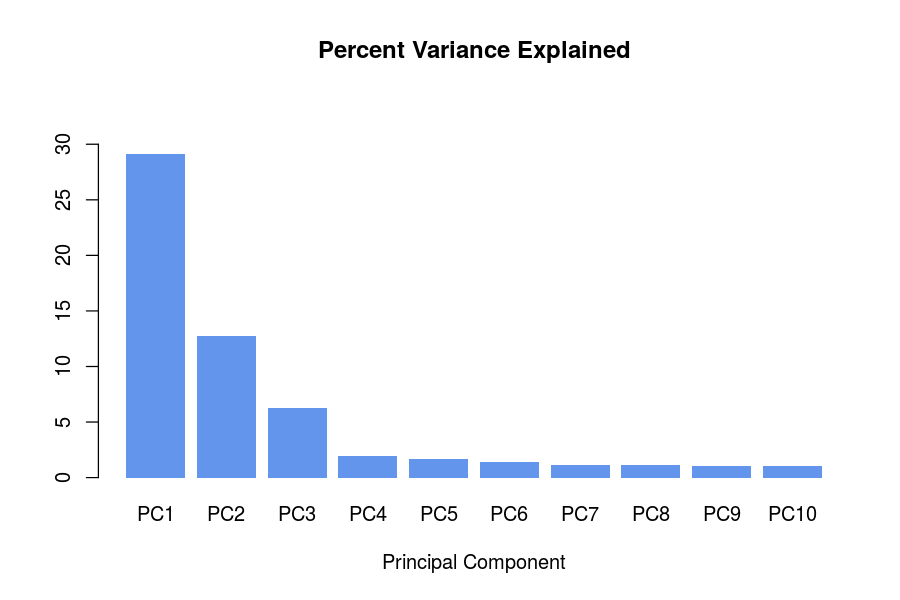

In [6]:
load("count_data.transformed.Rdata") #optional unless you are starting the analysis from here

#Run PCA and get % variance
pca.results <- prcomp(t(vst.all), center=T, scale.=T)
dspace <- pca.results$x #transformed dataspace

#Define plot properties
options(repr.plot.width=7.5, repr.plot.height=5)

#Percent of Variance Explained for PCs 1-10
pca.var <- summary(pca.results)
barplot(pca.var$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var$importance[2,1:10]*100)+5))


Based on the truncated scree plot above, PCs 1, 2, and 3 account for most of the variance in the data, so we will look at those PCs.

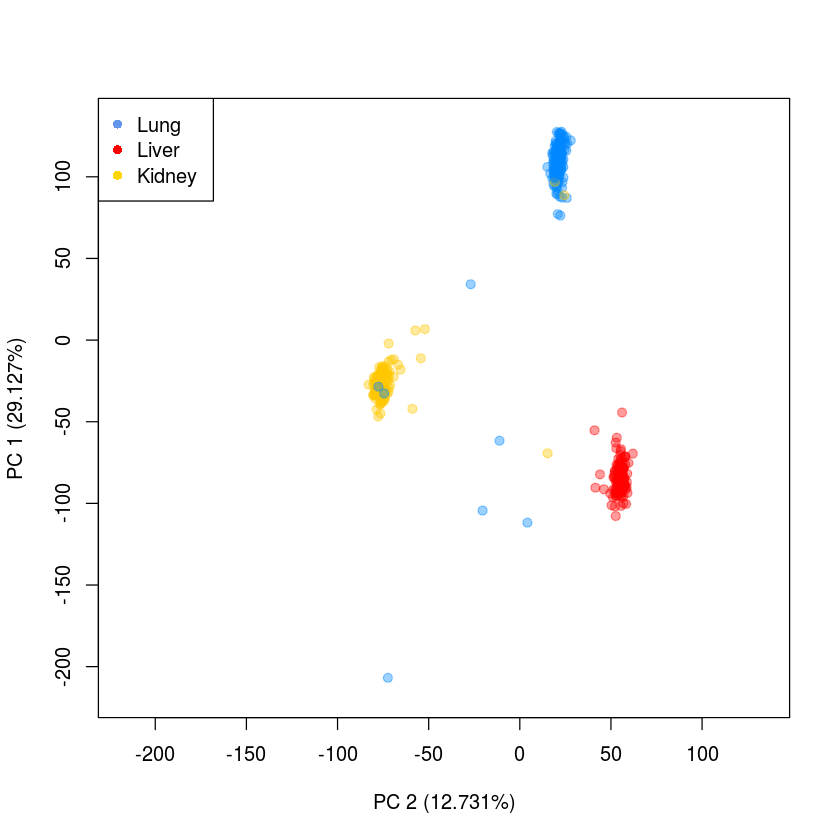

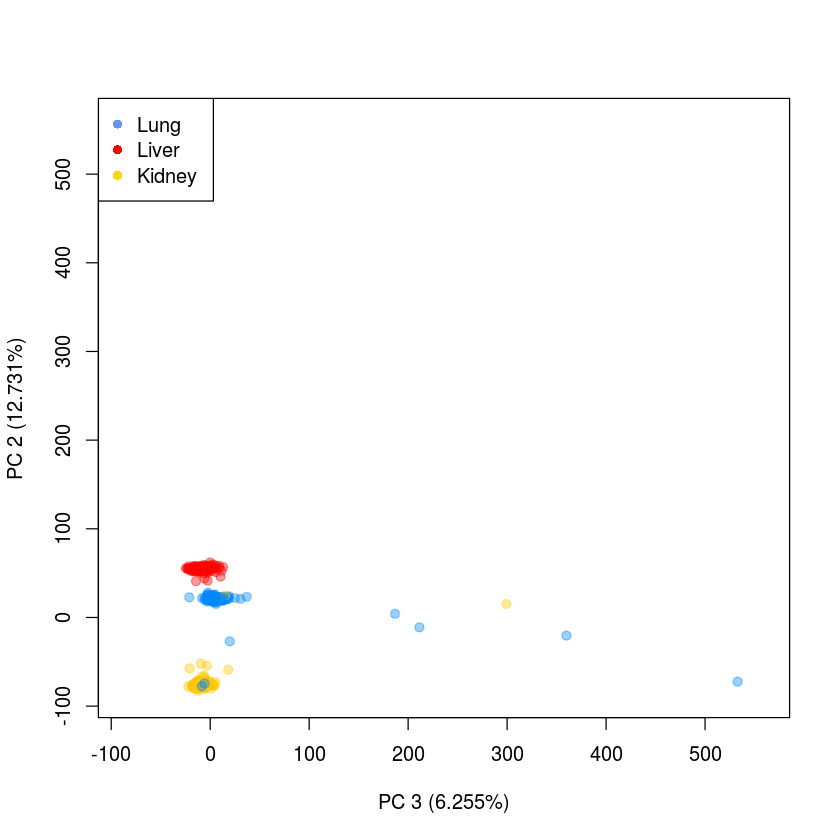

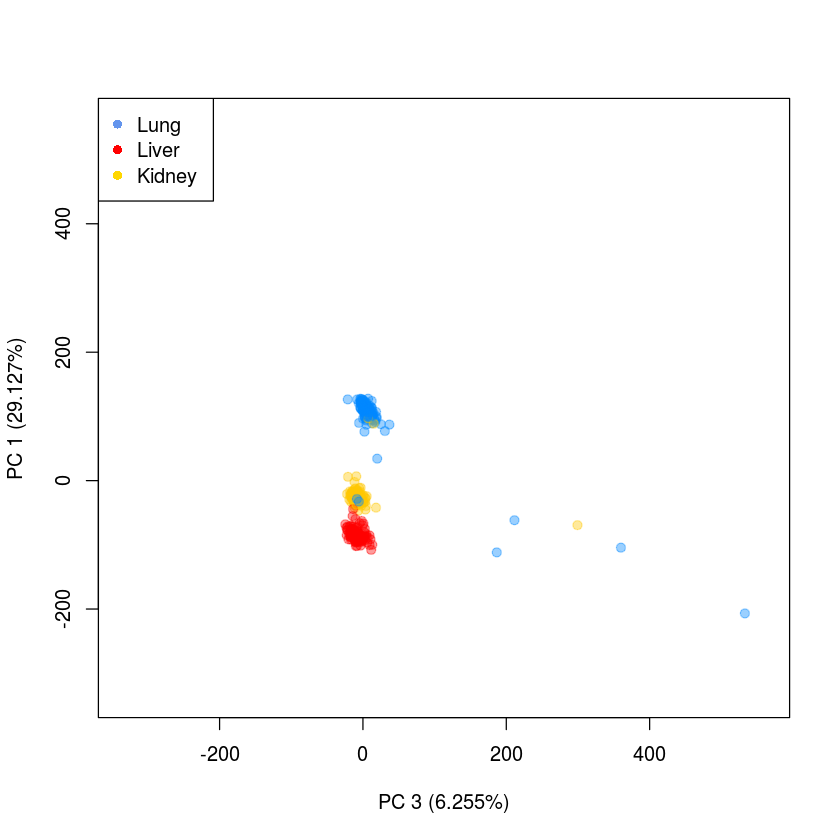

In [8]:
#Define plot properties
pc1.pov <- pca.var$importance[2,1]*100
pc2.pov <- pca.var$importance[2,2]*100
pc3.pov <- pca.var$importance[2,3]*100
options(repr.plot.width=7, repr.plot.height=7)
sample.names <- rownames(dspace)
colors <- rep(NA, length(sample.names))
lung <- grepl("LUNG", sample.names, fixed=T)
kidney <- grepl("KIDNEY", sample.names, fixed=T)
liver <- grepl("LIVER", sample.names, fixed=T)
colors[which(lung)] <- rgb(0,136,255,100, maxColorValue=255) #lightblue
colors[which(liver)] <- rgb(255,0,0,100, maxColorValue=255) #red
colors[which(kidney)] <-  rgb(255,200,0,100, maxColorValue=255) #gold
scale = 1.05
plot.lim1 = c(min(dspace[,1], dspace[,2])*scale, max(dspace[,1], dspace[,2])*scale)
plot.lim2 = c(min(dspace[,3], dspace[,2])*scale, max(dspace[,3], dspace[,2])*scale)
plot.lim3 = c(min(dspace[,3], dspace[,4])*scale, max(dspace[,3], dspace[,4])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
legend.col = c("cornflowerblue", "red", "gold")
legend.lab = c("Lung", "Liver", "Kidney")

#PC1 vs PC2
plot(y=dspace[,1], x=dspace[,2], pch=21, col=colors, bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label)
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)

#PC2 vs PC3
plot(y=dspace[,2], x=dspace[,3], pch=21, col=colors, bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label)
legend("topleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA)

#PC1 vs PC3
plot(y=dspace[,1], x=dspace[,3], pch=21, col=colors, bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label)
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)

The above PCA plots show that in general, tissue specific gene expression profiles generate the most variability between samples, with some exceptions. We dig deeper into understanding these exceptions in the next section.

### Are the samples that previously did not group by tissue now clustering by tissue as expected?

Some of the samples are not clustering by tissue, and we speculate that these samples that appear to be outliers and not clustering with the three tissue groups are non-unique HTSF sequenced samples and TAMU sequenced samples. To investigate this, we apply density-based clustering on PCs 1 and 2 using `dbscan` to identify the data points that don't lie in their expected subspaces.

Unique HTSF sequenced samples with tissue type discrepancies: 0

Outlier Samples:

[,1]                   [,2]         [,3]          
[1,] Sample                 Tissue Label Tissue Cluster
[2,] KIDNEY_625ppm_120_htsf KIDNEY       OUTLIER       
[3,] LUNG_0ppm_19_htsf      LUNG         OUTLIER       
[4,] LUNG_0ppm_75_htsf      LUNG         OUTLIER       
[5,] LUNG_1500ppm_65_htsf   LUNG         OUTLIER       
[6,] LUNG_1500ppm_72_htsf   LUNG         OUTLIER       
[7,] LUNG_625ppm_117_htsf   LUNG         OUTLIER

Non-unique HTSF Samples:

[,1]                   [,2]         [,3]          
[1,] Sample                 Tissue Label Tissue Cluster
[2,] KIDNEY_625ppm_120_htsf KIDNEY       OUTLIER       
[3,] LUNG_0ppm_19_htsf      LUNG         OUTLIER       
[4,] LUNG_0ppm_75_htsf      LUNG         OUTLIER       
[5,] LUNG_1500ppm_65_htsf   LUNG         OUTLIER       
[6,] LUNG_1500ppm_72_htsf   LUNG         OUTLIER       
[7,] LUNG_625ppm_117_htsf   LUNG         OUTLIER

TAMU Samples:

[,1]                   [,2]         [,3]          
[1,] Sample                 Tissue Label Tissue Cluster
[2,] KIDNEY_0ppm_90_tamu    KIDNEY       LUNG          
[3,] KIDNEY_625ppm_123_tamu KIDNEY       LUNG          
[4,] LUNG_1500ppm_133_tamu  LUNG         KIDNEY        
[5,] LUNG_625ppm_117_tamu   LUNG         KIDNEY

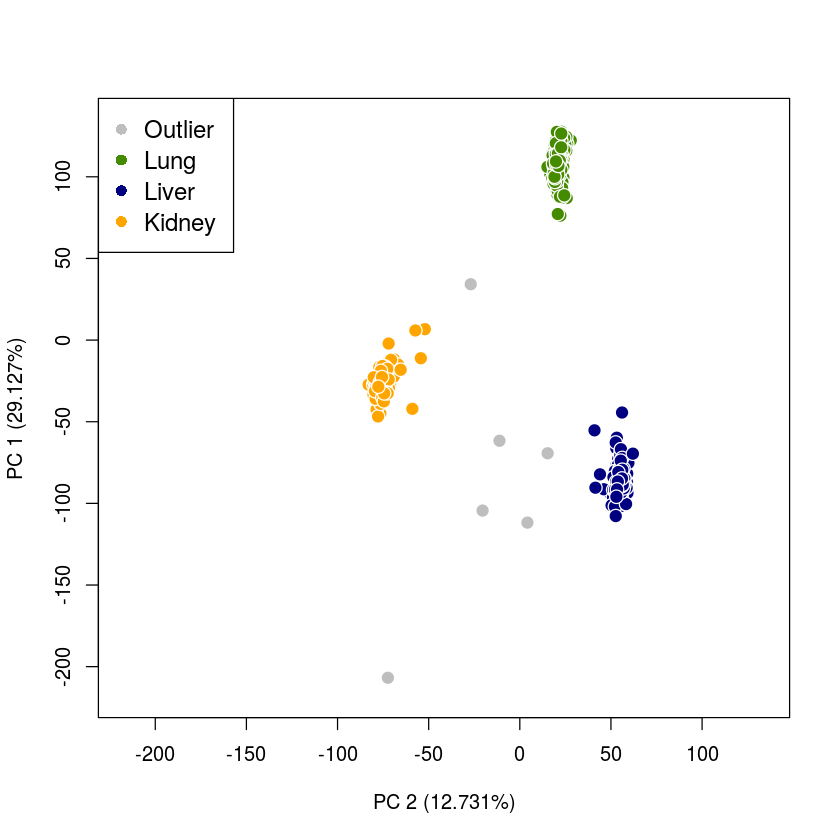

In [9]:
library(dbscan)
cluster = dbscan(x=dspace[,1:2],eps=25)$cluster
tissue.label <- sapply(strsplit(x=sample.names, split="_", fixed=T), function(x){x[1]})
tissue.cluster = as.vector(factor(cluster, levels=c(0,1,2,3), labels=c("OUTLIER", "KIDNEY", "LIVER", "LUNG")))
colors = as.vector(factor(cluster, levels=c(0,1,2,3), labels=c("gray", "orange", "navy", "chartreuse4")))
plot(y=dspace[,1], x=dspace[,2], pch=21, col="white", cex=1.5, bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label)
legend("topleft", 
       legend=c("Outlier", "Lung", "Liver", "Kidney"), 
       col=c("gray", "chartreuse4", "navy", "orange"), 
       pch=16,
       cex=1.2,
       bg=NA)

#Get indices for sample categories
unique.samples <- which(grepl(pattern="unique", sample.names, fixed=T)) 
htsf.samples <- which(grepl(pattern="htsf", sample.names, fixed=T))
tamu.samples <- which(grepl(pattern="tamu", sample.names, fixed=T))
htsf.bad <- htsf.samples[which(tissue.label[htsf.samples]!=tissue.cluster[htsf.samples])]
tamu.bad <- tamu.samples[which(tissue.label[tamu.samples]!=tissue.cluster[tamu.samples])]

cat("Unique HTSF sequenced samples with tissue type discrepancies: ", 
    length(which(tissue.label[unique.samples]!=tissue.cluster[unique.samples])),
    "\n\n", sep="")

cat("Outlier Samples:")
rbind(c("Sample","Tissue Label", "Tissue Cluster"), 
      cbind(sample.names[which(cluster==0)],
            tissue.label[which(cluster==0)],
            tissue.cluster[which(cluster==0)]))

cat("Non-unique HTSF Samples:")
rbind(c("Sample","Tissue Label", "Tissue Cluster"), 
      cbind(sample.names[htsf.bad], 
            tissue.label[htsf.bad], 
            tissue.cluster[htsf.bad]))

cat("TAMU Samples:")
rbind(c("Sample","Tissue Label", "Tissue Cluster"), 
      cbind(sample.names[tamu.bad], 
            tissue.label[tamu.bad], 
            tissue.cluster[tamu.bad]))

From the clustering, we see that the outliers (gray points) are all problematic HTSF samples that have all been resequenced. After re-sequencing at TAMU, most of these samples became clustered into their expected tissue groups. `LUNG_625ppm_117_htsf` was the only re-sequenced sample (`LUNG_625ppm_117_tamu`) that did not fall into its expected tissue cluster. Interestingly, four of the TAMU sequenced samples in the table above did not fall into their expected tissue clusters.

## Do we observe a batch effect for samples sequenced by both HTSF and TAMU?

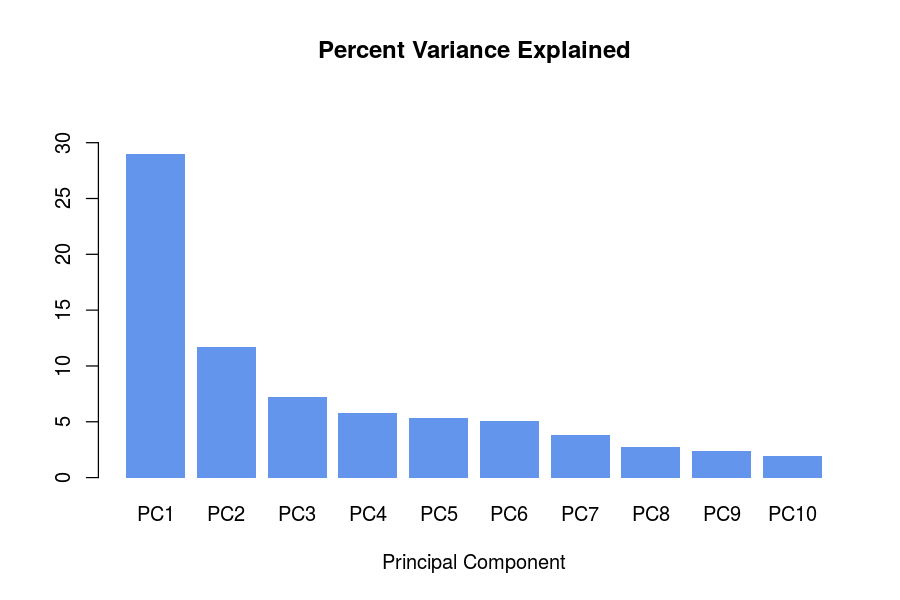

In [10]:
#Run PCA and get % variance
pca.results <- prcomp(t(vst.htsf.tamu), center=T, scale.=T)
dspace <- pca.results$x #transformed dataspace

#Define plot properties
options(repr.plot.width=7.5, repr.plot.height=5)

#Percent of Variance Explained for PCs 1-10
pca.var <- summary(pca.results)
barplot(pca.var$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var$importance[2,1:10]*100)+5))

Based on the truncated scree plot above, PCs 1, 2, and 3 account for a good portion of the variance in the data, so we will look at those PCs.

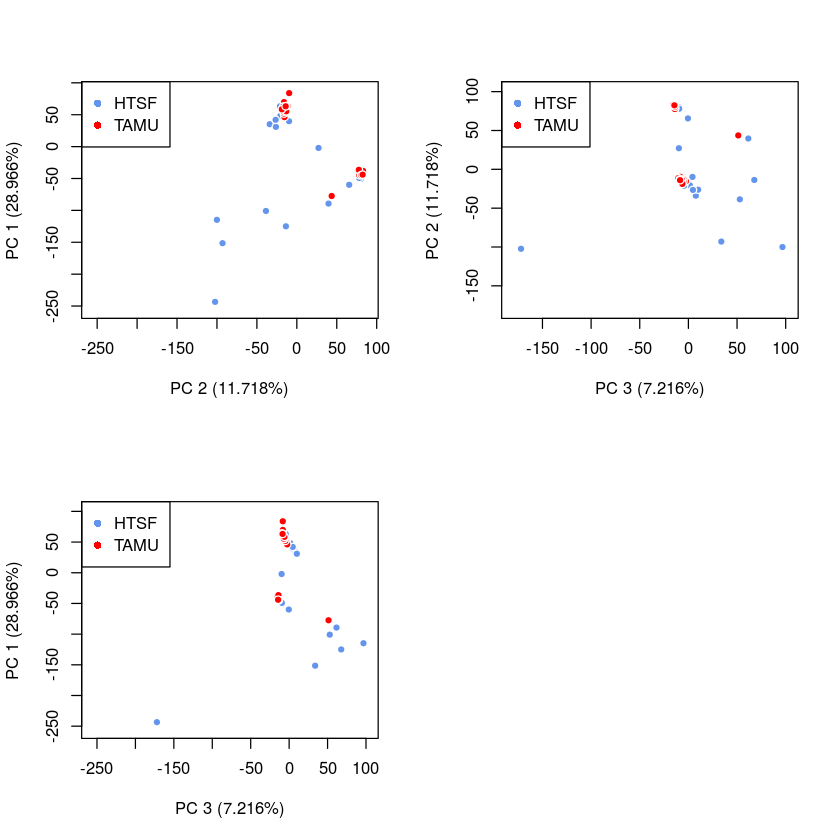

In [11]:
#Define plot properties
pc1.pov <- pca.var$importance[2,1]*100
pc2.pov <- pca.var$importance[2,2]*100
pc3.pov <- pca.var$importance[2,3]*100
options(repr.plot.width=7, repr.plot.height=7)
sample.names <- rownames(dspace)
colors <- rep(NA, length(sample.names))
colors[grepl("htsf", sample.names, fixed=T)] <- "cornflowerblue"
colors[grepl("tamu", sample.names, fixed=T)] <- "red"
scale = 1.05
plot.lim1 = c(min(dspace[,1], dspace[,2])*scale, max(dspace[,1], dspace[,2])*scale)
plot.lim2 = c(min(dspace[,3], dspace[,2])*scale, max(dspace[,3], dspace[,2])*scale)
plot.lim3 = c(min(dspace[,1], dspace[,3])*scale, max(dspace[,1], dspace[,3])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
legend.col = c("cornflowerblue", "red")
legend.lab = c("HTSF", "TAMU")

par(mfrow=c(2,2))
#PC1 vs PC2
plot(y=dspace[,1], x=dspace[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label)
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)

#PC2 vs PC3
plot(y=dspace[,2], x=dspace[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label)
legend("topleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA)

#PC1 vs PC3
plot(y=dspace[,1], x=dspace[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label)
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA)


Based on our observations of the PCA plots above, there does not appear to be strong batch effects from having the samples sequenced at different sequencing centers.

### Do we see a differences between exposure groups within tissue?

If there are consistent drastic trends in gene expression profile changes between treatment groups, we would expect these to be noticeable by PCA. The plots below assess this expectation.

In [7]:
#Run PCA and get % variance
pca.results.liver <- prcomp(t(vst.liver), center=T, scale.=T)
pca.results.lung <- prcomp(t(vst.lung), center=T, scale.=T)
pca.results.kidney <- prcomp(t(vst.kidney), center=T, scale.=T)
dspace.liver <- pca.results.liver$x #transformed dataspace
dspace.lung <- pca.results.lung$x #transformed dataspace
dspace.kidney <- pca.results.kidney$x #transformed dataspace

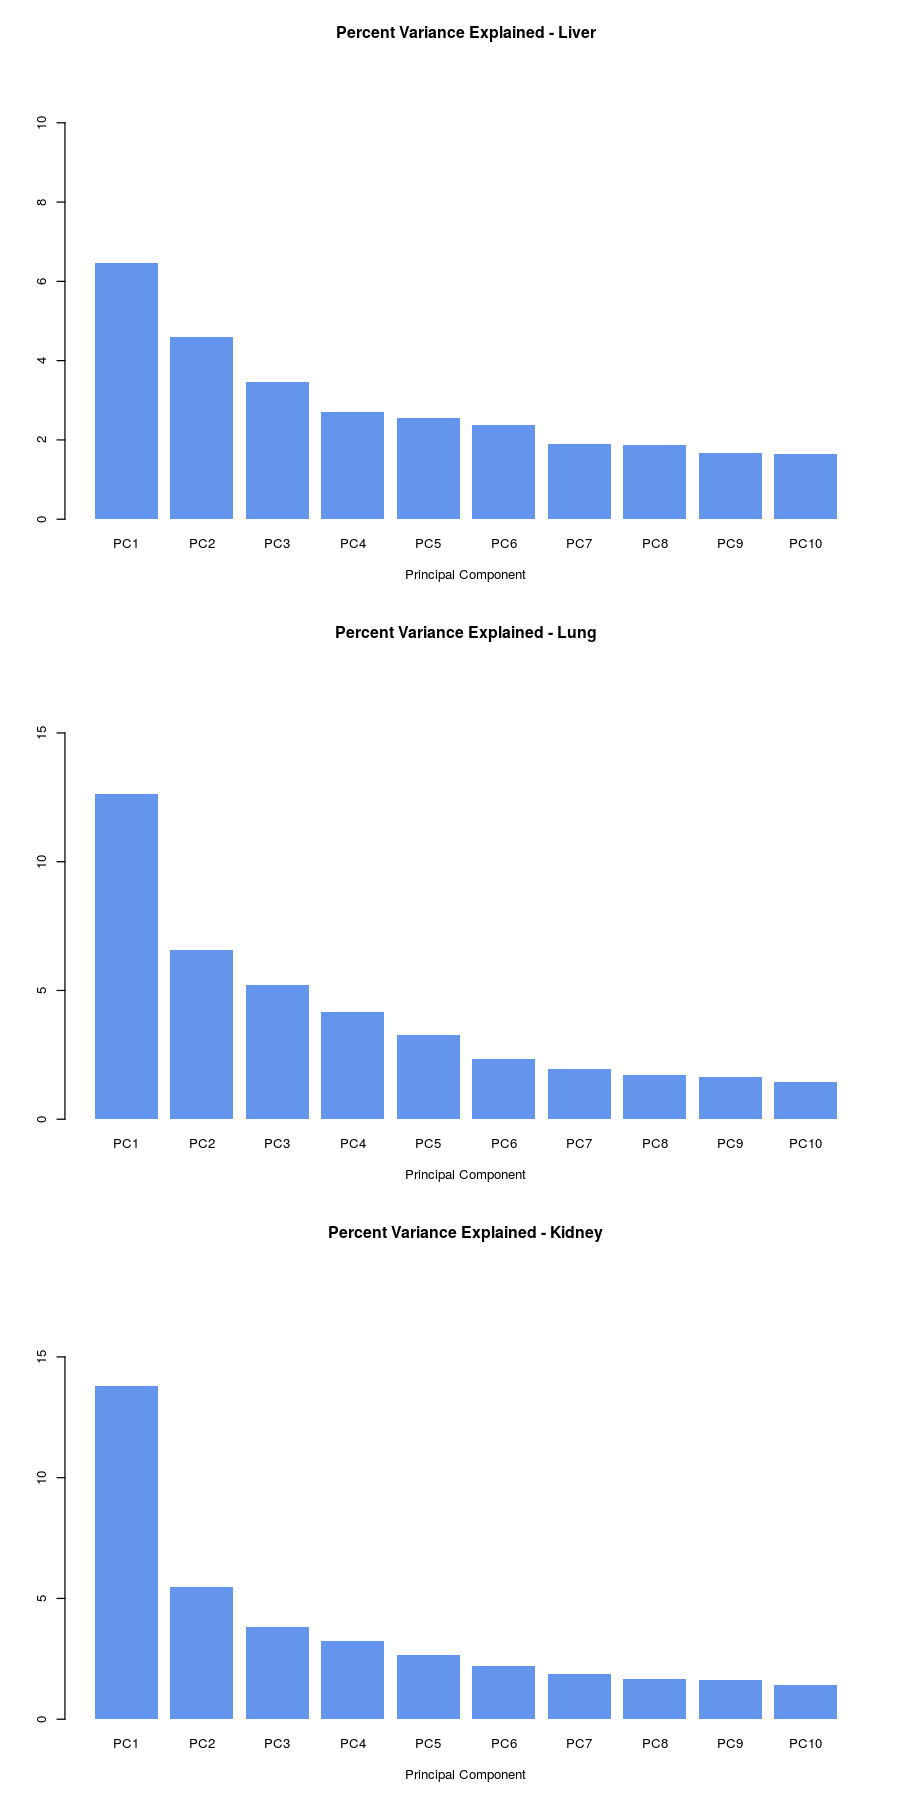

In [8]:
#Define plot properties
options(repr.plot.width=7.5, repr.plot.height=15)

#Percent of Variance Explained for PCs 1-10
par(mfrow=c(3,1))
pca.var.liver <- summary(pca.results.liver)
pca.var.lung <- summary(pca.results.lung)
pca.var.kidney <- summary(pca.results.kidney)
barplot(pca.var.liver$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Liver", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.liver$importance[2,1:10]*100)+5))
barplot(pca.var.lung$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Lung", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.lung$importance[2,1:10]*100)+5))
barplot(pca.var.kidney$importance[2,1:10]*100, 
        col="cornflowerblue", 
        border=NA, 
        main="Percent Variance Explained - Kidney", 
        xlab="Principal Component", 
        ylim=c(0, max(pca.var.kidney$importance[2,1:10]*100)+5))

In the truncated scree plots above, the reduction in variance explained with each additional PC is not as drastic as in previous analyses, so we will explore up to PC5.

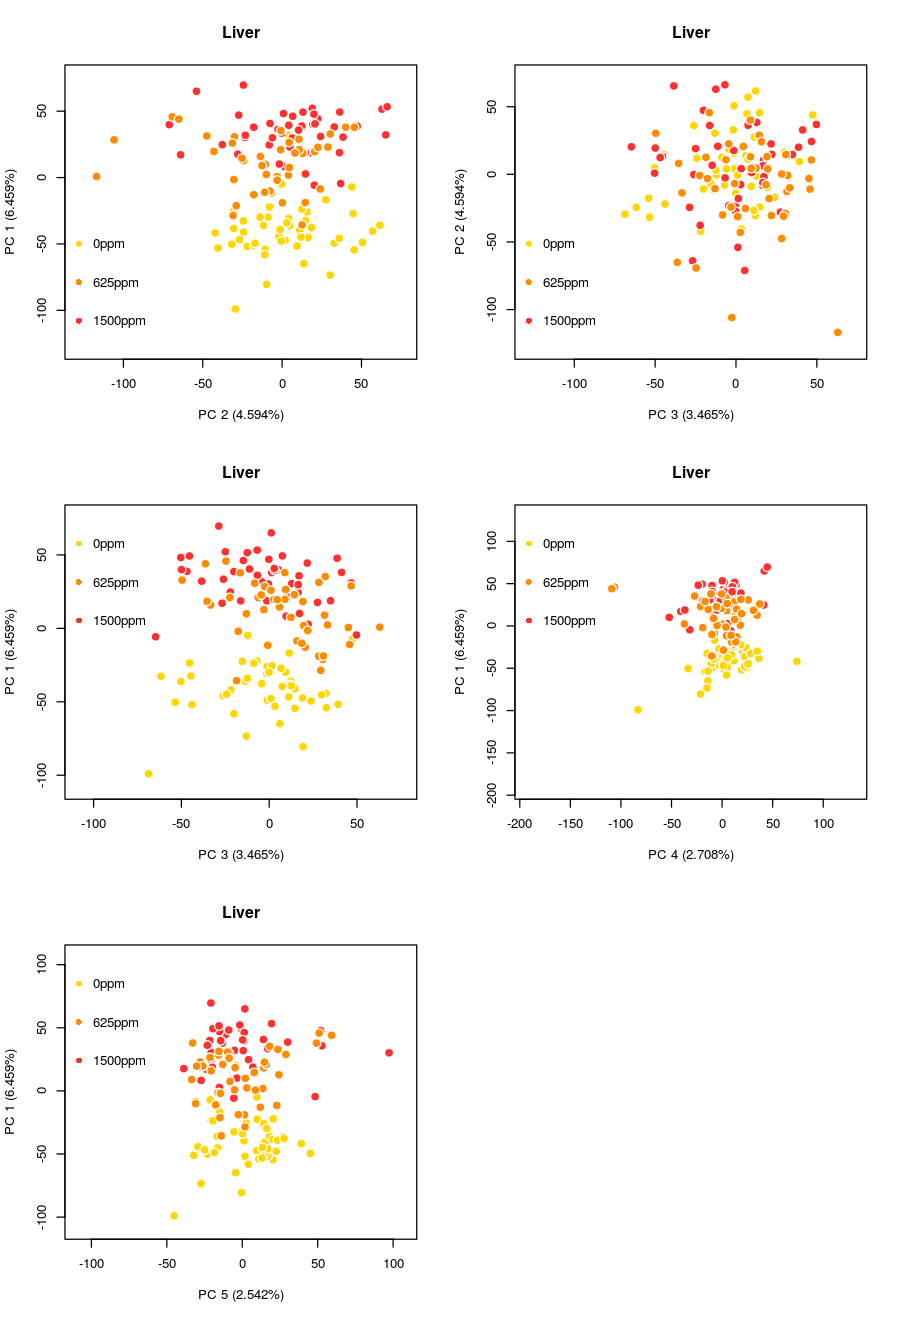

In [9]:
#PCA plots for liver tissue

#Define plot properties
pc1.pov <- pca.var.liver$importance[2,1]*100
pc2.pov <- pca.var.liver$importance[2,2]*100
pc3.pov <- pca.var.liver$importance[2,3]*100
pc4.pov <- pca.var.liver$importance[2,4]*100
pc5.pov <- pca.var.liver$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.liver)
colors <- rep(NA, length(sample.names))
colors[grepl("_0ppm", sample.names, fixed=T)] <- "gold"
colors[grepl("625ppm", sample.names, fixed=T)] <- "darkorange"
colors[grepl("1500ppm", sample.names, fixed=T)] <- "firebrick1"
scale = 1.1
plot.lim1 = c(min(dspace.liver[,1], dspace.liver[,2])*scale, max(dspace.liver[,1], dspace.liver[,2])*scale)
plot.lim2 = c(min(dspace.liver[,3], dspace.liver[,2])*scale, max(dspace.liver[,3], dspace.liver[,2])*scale)
plot.lim3 = c(min(dspace.liver[,1], dspace.liver[,3])*scale, max(dspace.liver[,1], dspace.liver[,3])*scale)
plot.lim4 = c(min(dspace.liver[,1], dspace.liver[,4])*scale*1.6, max(dspace.liver[,1], dspace.liver[,4])*scale*1.6)
plot.lim5 = c(min(dspace.liver[,1], dspace.liver[,5])*scale, max(dspace.liver[,1], dspace.liver[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "darkorange", "firebrick1")
legend.lab = c("0ppm", "625ppm", "1500ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.liver[,1], x=dspace.liver[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5, 
     main="Liver")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.liver[,2], x=dspace.liver[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5, 
     main="Liver")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC1 vs PC3
plot(y=dspace.liver[,1], x=dspace.liver[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC1 vs PC4
plot(y=dspace.liver[,1], x=dspace.liver[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc1.label, xlab=pc4.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC1 vs PC5
plot(y=dspace.liver[,1], x=dspace.liver[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc1.label, xlab=pc5.label,
     cex=1.5, 
     main="Liver")
legend("topleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")



PC1 Outlier Samples:
LUNG_1500ppm_133_tamu
LUNG_625ppm_117_tamu


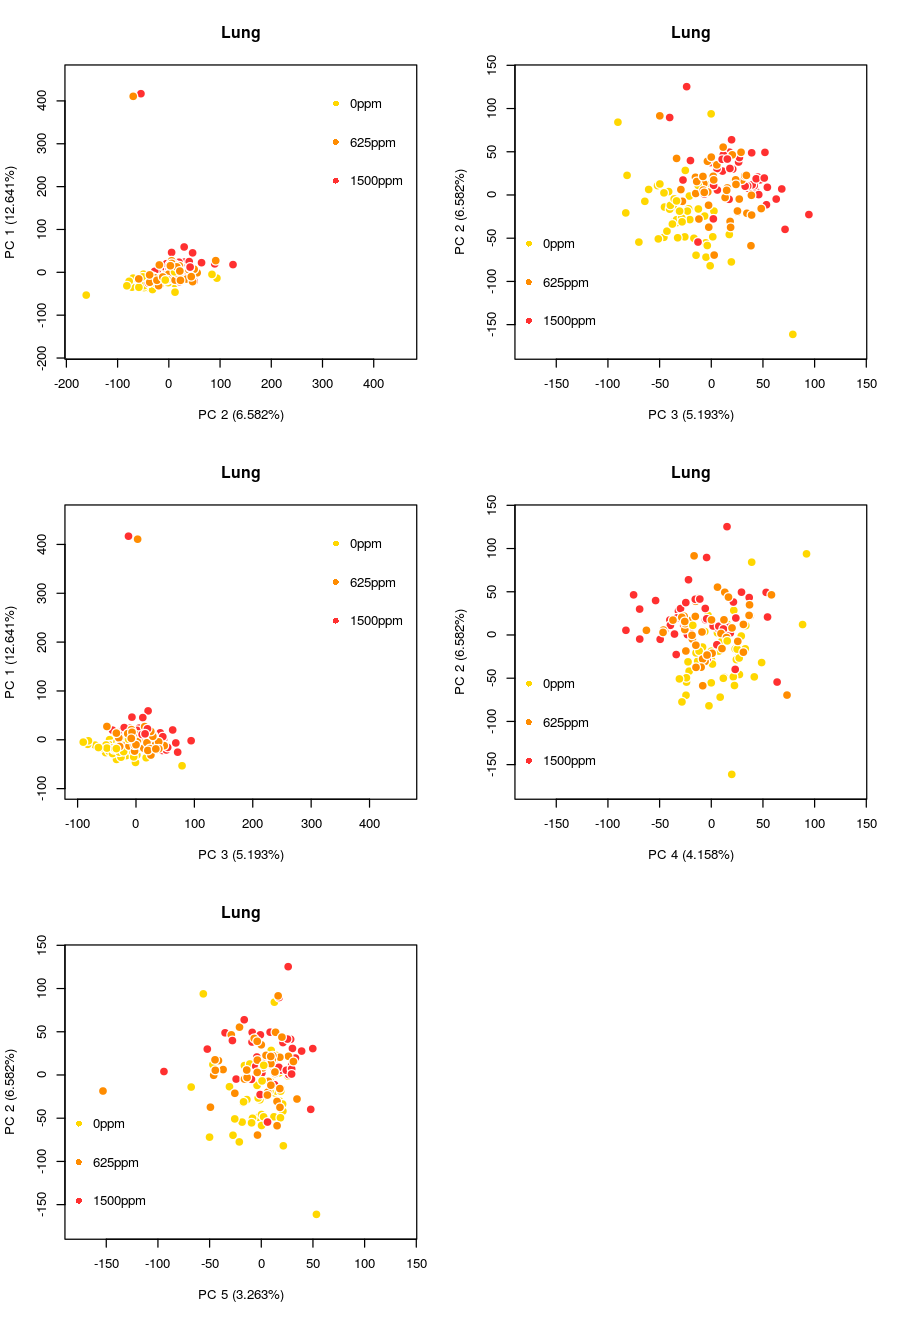

In [10]:
#PCA plots for lung tissue

#Define plot properties
pc1.pov <- pca.var.lung$importance[2,1]*100
pc2.pov <- pca.var.lung$importance[2,2]*100
pc3.pov <- pca.var.lung$importance[2,3]*100
pc4.pov <- pca.var.lung$importance[2,4]*100
pc5.pov <- pca.var.lung$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.lung)
colors <- rep(NA, length(sample.names))
colors[grepl("_0ppm", sample.names, fixed=T)] <- "gold"
colors[grepl("625ppm", sample.names, fixed=T)] <- "darkorange"
colors[grepl("1500ppm", sample.names, fixed=T)] <- "firebrick1"
scale = 1.1
plot.lim1 = c(min(dspace.lung[,1], dspace.lung[,2])*scale, max(dspace.lung[,1], dspace.lung[,2])*scale)
plot.lim2 = c(min(dspace.lung[,3], dspace.lung[,2])*scale, max(dspace.lung[,3], dspace.lung[,2])*scale)
plot.lim3 = c(min(dspace.lung[,1], dspace.lung[,3])*scale, max(dspace.lung[,1], dspace.lung[,3])*scale)
plot.lim4 = c(min(dspace.lung[,2], dspace.lung[,4])*scale, max(dspace.lung[,2], dspace.lung[,4])*scale)
plot.lim5 = c(min(dspace.lung[,2], dspace.lung[,5])*scale, max(dspace.lung[,2], dspace.lung[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "darkorange", "firebrick1")
legend.lab = c("0ppm", "625ppm", "1500ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.lung[,1], x=dspace.lung[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5,
     main="Lung")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.lung[,2], x=dspace.lung[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5,
     main="Lung")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC1 vs PC3
plot(y=dspace.lung[,1], x=dspace.lung[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc1.label, xlab=pc3.label,
     cex=1.5,
     main="Lung")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC4
plot(y=dspace.lung[,2], x=dspace.lung[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc2.label, xlab=pc4.label,
     cex=1.5,
     main="Lung")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC5
plot(y=dspace.lung[,2], x=dspace.lung[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc2.label, xlab=pc5.label,
     cex=1.5,
     main="Lung")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")


cat("PC1 Outlier Samples:", names(which(dspace.lung[,1]>300)), sep="\n")

The PCA plots above show two outlier samples along the PC1 axis which are the samples that the global PCA analysis suggested belong in the kidney tissue group. Since these outlier samples are driving the PC1 variance, we look at the PC2 vs PC3 plot and see a separation between control and 1,3-butadiene exposed groups.

PC1 Outlier Samples:
KIDNEY_0ppm_90_tamu
KIDNEY_625ppm_123_tamu


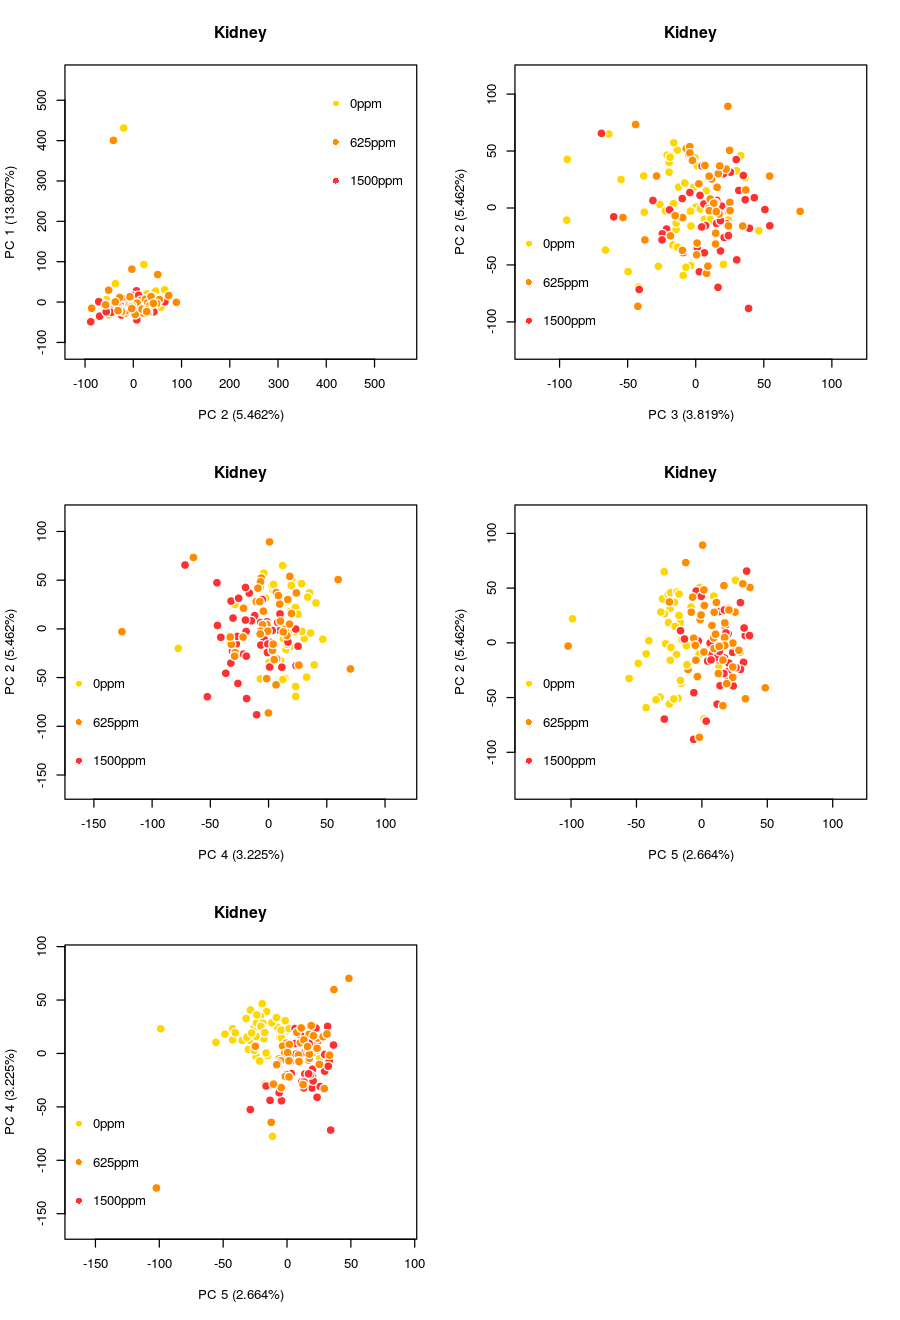

In [11]:
#PCA plots for kidney tissue

#Define plot properties
pc1.pov <- pca.var.kidney$importance[2,1]*100
pc2.pov <- pca.var.kidney$importance[2,2]*100
pc3.pov <- pca.var.kidney$importance[2,3]*100
pc4.pov <- pca.var.kidney$importance[2,4]*100
pc5.pov <- pca.var.kidney$importance[2,5]*100
options(repr.plot.width=7.5, repr.plot.height=11)
sample.names <- rownames(dspace.kidney)
colors <- rep(NA, length(sample.names))
colors[grepl("_0ppm", sample.names, fixed=T)] <- "gold"
colors[grepl("625ppm", sample.names, fixed=T)] <- "darkorange"
colors[grepl("1500ppm", sample.names, fixed=T)] <- "firebrick1"
scale = 1.3
plot.lim1 = c(min(dspace.kidney[,1], dspace.kidney[,2])*scale, max(dspace.kidney[,1], dspace.kidney[,2])*scale)
plot.lim2 = c(min(dspace.kidney[,3], dspace.kidney[,2])*scale, max(dspace.kidney[,3], dspace.kidney[,2])*scale)
plot.lim3 = c(min(dspace.kidney[,2], dspace.kidney[,4])*scale, max(dspace.kidney[,2], dspace.kidney[,4])*scale)
plot.lim4 = c(min(dspace.kidney[,2], dspace.kidney[,5])*scale, max(dspace.kidney[,2], dspace.kidney[,5])*scale)
plot.lim5 = c(min(dspace.kidney[,4], dspace.kidney[,5])*scale, max(dspace.kidney[,4], dspace.kidney[,5])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
pc3.label = paste("PC 3 (",pc3.pov,"%)",sep="")
pc4.label = paste("PC 4 (",pc4.pov,"%)",sep="")
pc5.label = paste("PC 5 (",pc5.pov,"%)",sep="")
legend.col = c("gold", "darkorange", "firebrick1")
legend.lab = c("0ppm", "625ppm", "1500ppm")

par(mfrow=c(3,2))
#PC1 vs PC2
plot(y=dspace.kidney[,1], x=dspace.kidney[,2], pch=21, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.5,
     main="Kidney")
legend("topright", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC3
plot(y=dspace.kidney[,2], x=dspace.kidney[,3], pch=21, col="white", bg=colors, 
     xlim=plot.lim2, ylim=plot.lim2, 
     ylab=pc2.label, xlab=pc3.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft",
       legend=legend.lab,
       col=legend.col,
       pch=16,
       bg=NA, bty="n")

#PC2 vs PC4
plot(y=dspace.kidney[,2], x=dspace.kidney[,4], pch=21, col="white", bg=colors, 
     xlim=plot.lim3, ylim=plot.lim3, 
     ylab=pc2.label, xlab=pc4.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC2 vs PC5
plot(y=dspace.kidney[,2], x=dspace.kidney[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim4, ylim=plot.lim4, 
     ylab=pc2.label, xlab=pc5.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")

#PC4 vs PC5
plot(y=dspace.kidney[,4], x=dspace.kidney[,5], pch=21, col="white", bg=colors, 
     xlim=plot.lim5, ylim=plot.lim5, 
     ylab=pc4.label, xlab=pc5.label,
     cex=1.5,
     main="Kidney")
legend("bottomleft", 
       legend=legend.lab, 
       col=legend.col, 
       pch=16, 
       bg=NA, bty="n")


cat("PC1 Outlier Samples:", names(which(dspace.kidney[,1]>300)), sep="\n")

The PCA plots above show two outlier samples along the PC1 axis which are the samples that the global PCA analysis suggested belong in the lung tissue group. These results in concordance with the lung tissue PCA results suggest that there may have been a sample swap. In kidney tissue, the contrast between exposure groups does not appear as stark as in lung and liver. There is some visible separation between control and 1,3-butadiene exposed groups in PC4 and PC5.

## Sample mislabeling correction

In this section we attempt to address two sample labeling issues:

* For CC strain CC020, there is a sample for mouse #124 labeled as lung tissue for 1500ppm 1,3-butadiene exposure. All the other samples for mouse #124 are for 625ppm 1,3-butadiene exposure. Can we decipher visually if this sample was mislabeled?
* Two kidney and two lung samples sequenced at TAMU appear to be swapped. Can we increase our confidence of their correct sample names using evidence from clustering?


### Analysis of CC strain CC020

There is a sample for mouse #124 labeled as lung tissue for 1500ppm 1,3-butadiene exposure. All the other samples for mouse #124 are for 625ppm 1,3-butadiene exposure. To decipher if this sample was mislabeled, we look at a PCA plot of samples for the three mice we have that are from strain CC020.

In [290]:
pca.results <- prcomp(t(vst.cc020), center=T, scale.=T)
dspace <- pca.results$x #transformed dataspace

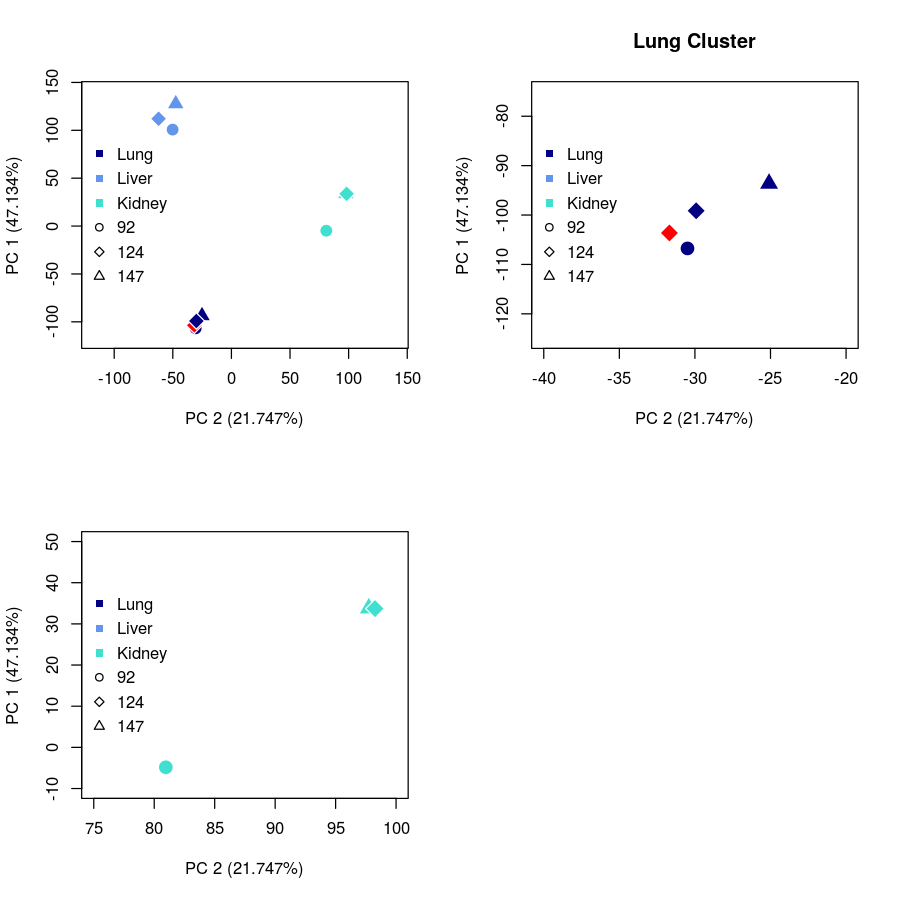

In [291]:
#Define plot properties
pca.var <- summary(pca.results)
pc1.pov <- pca.var$importance[2,1]*100
pc2.pov <- pca.var$importance[2,2]*100
options(repr.plot.width=7.5, repr.plot.height=7.5)
sample.names <- rownames(dspace)
colors <- rep(NA, length(sample.names))
pts <- rep(NA, length(sample.names))
colors[grepl("LUNG", sample.names, fixed=T)] <- "navy"
colors[grepl("LIVER", sample.names, fixed=T)] <- "cornflowerblue"
colors[grepl("KIDNEY", sample.names, fixed=T)] <- "turquoise"
colors[grepl("LUNG_1500ppm_124_unique", sample.names, fixed=T)] <- "red"
pts[grepl("_92_", sample.names, fixed=T)] <- 21
pts[grepl("_124_", sample.names, fixed=T)] <- 23
pts[grepl("_147_", sample.names, fixed=T)] <- 24

scale = 1.1
plot.lim1 = c(min(dspace[,1], dspace[,2])*scale, max(dspace[,1], dspace[,2])*scale)
pc1.label = paste("PC 1 (",pc1.pov,"%)",sep="")
pc2.label = paste("PC 2 (",pc2.pov,"%)",sep="")
legend.col = c("navy", "cornflowerblue", "turquoise", "black", "black", "black")
legend.lab = c("Lung", "Liver", "Kidney", "92", "124", "147")
legend.pts = c(15,15,15,21,23,24)

par(mfrow=c(2,2))
#PC1 vs PC2
plot(y=dspace[,1], x=dspace[,2], pch=pts, col="white", bg=colors, 
     xlim=plot.lim1, ylim=plot.lim1,
     ylab=pc1.label, xlab=pc2.label,
     cex=1.75)
legend("left", 
       legend=legend.lab, 
       col=legend.col, 
       pch=legend.pts, 
       bg=NA, bty="n")

#Lung zoomed in
plot(y=dspace[,1], x=dspace[,2], pch=pts, col="white", bg=colors, 
     xlim=c(-40,-20), ylim=c(-125,-75),
     ylab=pc1.label, xlab=pc2.label,
     cex=2, main="Lung Cluster")
legend("left", 
       legend=legend.lab, 
       col=legend.col, 
       pch=legend.pts, 
       bg=NA, bty="n")

#Kidney zoomed in
plot(y=dspace[,1], x=dspace[,2], pch=pts, col="white", bg=colors, 
     xlim=c(75,100), ylim=c(-10,50),
     ylab=pc1.label, xlab=pc2.label,
     cex=2, main=)
legend("left", 
       legend=legend.lab, 
       col=legend.col, 
       pch=legend.pts, 
       bg=NA, bty="n")


The red point in the PCA plots is sample `LUNG_1500ppm_124_unique`. The plots suggest that the sample is indeed Kidney, so the remaining question is, is this sample for mouse 124 or 147? As an attempt to answer this question, we applied correlation based hierarchical clustering on gene expression profiles for lung tissue samples.

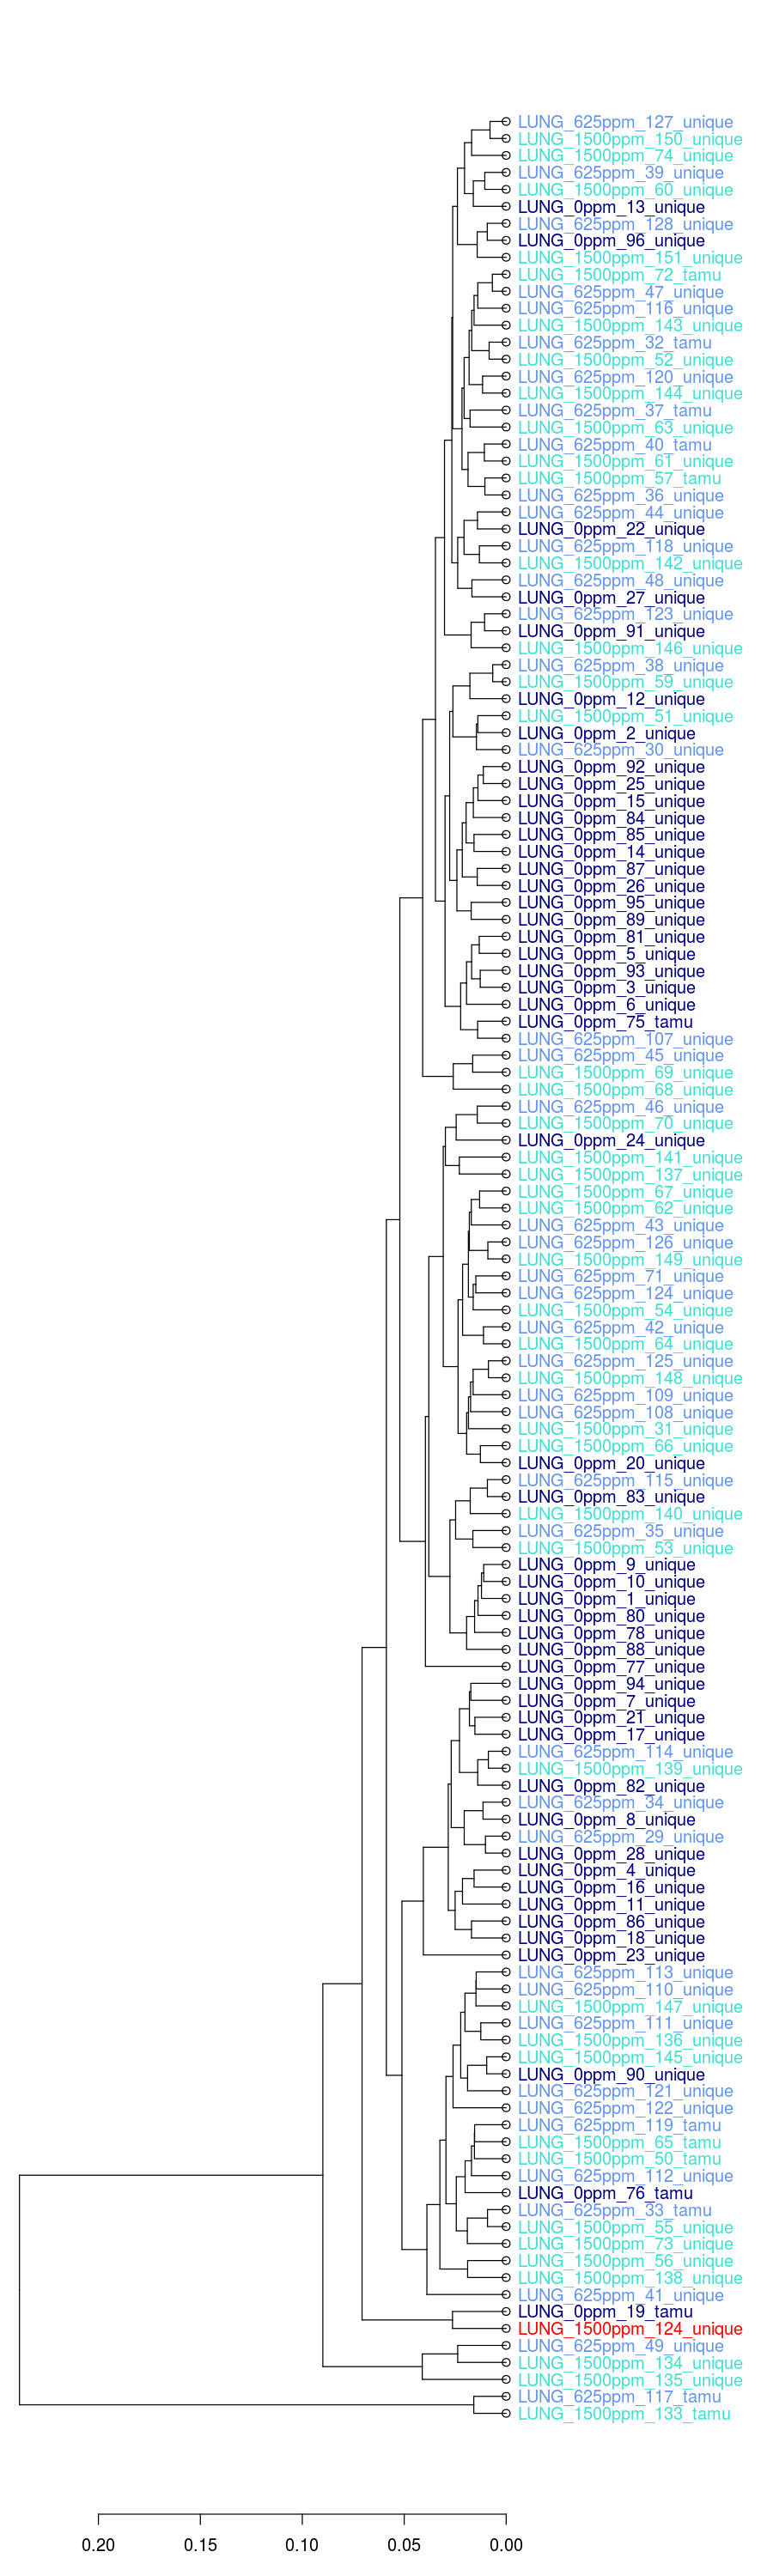

In [292]:
#Calculate Pearson correlation and cluster
cor.dist <- as.dist(1-cor(vst.lung))
hc <- hclust(d=cor.dist)

#Color dendrogram labels
labelCol <- function(x) {
    if (is.leaf(x)) {
        #fetch label
        label <- attr(x, "label")
        if (strsplit(label,split="_")[[1]][2]=="0ppm") {
            attr(x,"nodePar") <- list(lab.col="navy")
        }else if(strsplit(label,split="_")[[1]][2]=="625ppm"){
            attr(x,"nodePar") <- list(lab.col="cornflowerblue")
        }else {
            attr(x,"nodePar") <- list(lab.col="turquoise")
        }
        if (label=="LUNG_1500ppm_124_unique") {
            attr(x,"nodePar") <- list(lab.col="red")
        }
    }
    return(x)
}
hcd <- dendrapply(as.dendrogram(hc), labelCol)

#Plot dendrogram
options(repr.plot.width=7.5, repr.plot.height=25)
par(mar=c(3,0,1,12)) 
plot(hcd, horiz=T, cex=0.2)

The sample we want to classify is in red in the dendrogram. The hope was that samples would more strongly cluster by treatment group, allowing us to see into which treatment group the `Lung_1500ppm_124_unique` sample fell. The samples do not cluster by treatment group, so this approach proved uninformative.

### Resolving names for two kidney and two lung samples sequenced at TAMU

For the samples re-sequenced at TAMU, the following did not cluster into the expected tissue group:

* KIDNEY_0ppm_90_tamu
* KIDNEY_625ppm_123_tamu
* LUNG_1500ppm_133_tamu
* LUNG_625ppm_117_tamu

Both kidney samples clustered into the lung tissue group, and both lung samples clustered into the kidney tissue group, which hints at the possibility of sample mislabeling. The HTSF samples for `KIDNEY_0ppm_90_tamu`, `KIDNEY_625ppm_123_tamu`, and `LUNG_1500ppm_133_tamu` clustered into their expected tissue groups, so we would expect that these samples will cluster with their analogous HTSF sequenced sample. We apply hierarchical clustering to see if these expectations hold true. To mitigate any batch effects, we re-normalize the data with batch taken into account.

In [13]:
#Re-normalize data with batch info included
sample.info = DataFrame(rep(NA, length(colnames(htsf.tamu.cts))), row.names = colnames(htsf.tamu.cts))
sample.info[grepl(rownames(sample.info), pattern="htsf"),] <- "HTSF"
sample.info[grepl(rownames(sample.info), pattern="tamu"),] <- "TAMU"
colnames(sample.info) <- "batch"
dds.htsf.tamu <- DESeqDataSetFromMatrix(htsf.tamu.cts, sample.info, ~batch)
dds.htsf.tamu <- dds.htsf.tamu[rowSums(counts(dds.htsf.tamu))>1,]
dds.htsf.tamu.vst <- vst(dds.htsf.tamu, blind=F, nsub=10000)
vst.htsf.tamu <- assay(dds.htsf.tamu.vst)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

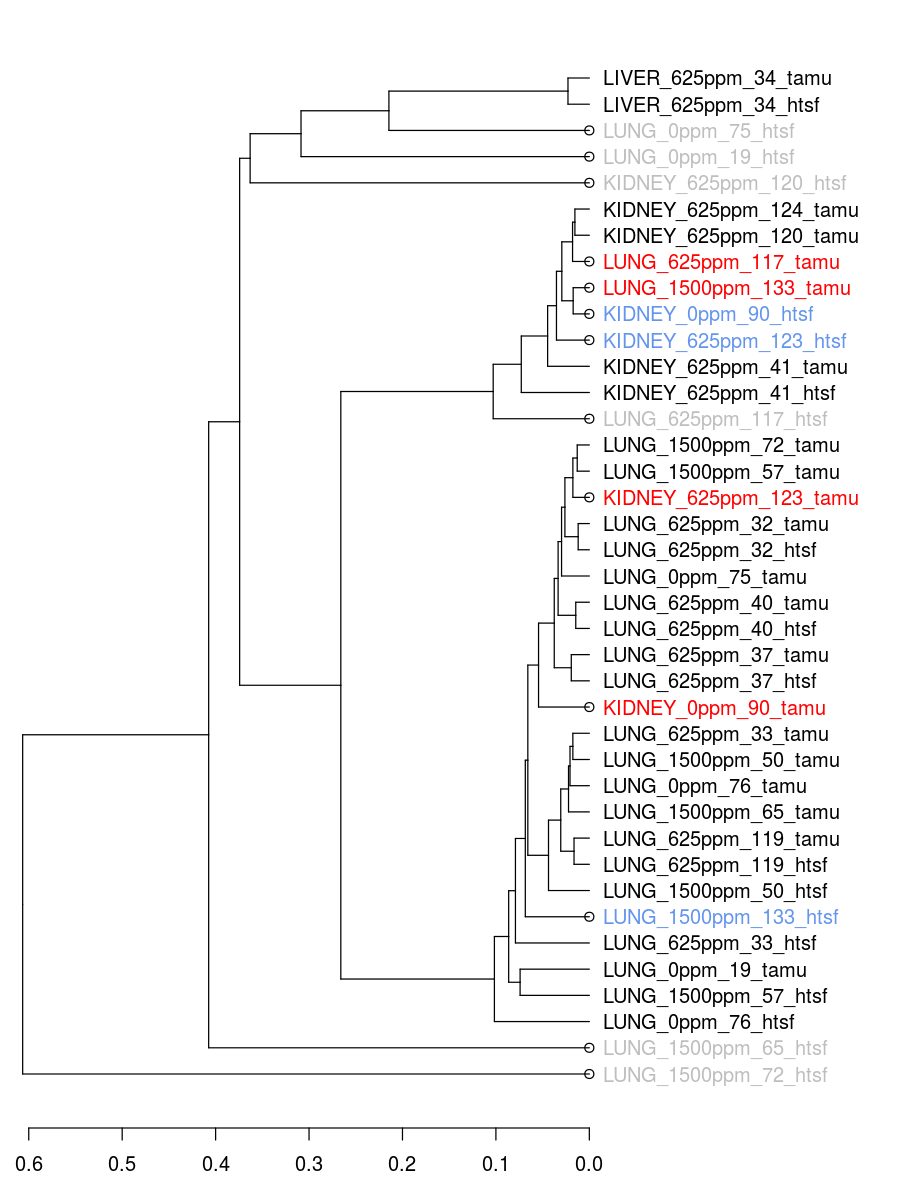

In [14]:
#Calculate Pearson correlation and cluster
cor.dist <- as.dist(1-cor(vst.htsf.tamu))
hc <- hclust(d=cor.dist)

#Color dendrogram labels
labelCol <- function(x) {
    if (is.leaf(x)) {
        #fetch label
        label <- attr(x, "label")
        if (label=="LUNG_1500ppm_133_tamu") {
            attr(x,"nodePar") <- list(lab.col="red")
        }
        if (label=="LUNG_625ppm_117_tamu") {
            attr(x,"nodePar") <- list(lab.col="red")
        }
        if (label=="KIDNEY_0ppm_90_tamu") {
            attr(x,"nodePar") <- list(lab.col="red")
        }
        if (label=="KIDNEY_625ppm_123_tamu") {
            attr(x,"nodePar") <- list(lab.col="red")
        }
        if (label=="LUNG_1500ppm_133_htsf") {
            attr(x,"nodePar") <- list(lab.col="cornflowerblue")
        }
        if (label=="LUNG_625ppm_117_htsf") {
            attr(x,"nodePar") <- list(lab.col="cornflowerblue")
        }
        if (label=="KIDNEY_0ppm_90_htsf") {
            attr(x,"nodePar") <- list(lab.col="cornflowerblue")
        }
        if (label=="KIDNEY_625ppm_123_htsf") {
            attr(x,"nodePar") <- list(lab.col="cornflowerblue")
        }
        if (label=="KIDNEY_625ppm_120_htsf") {
            attr(x,"nodePar") <- list(lab.col="gray")
        }
        if (label=="LUNG_0ppm_19_htsf") {
            attr(x,"nodePar") <- list(lab.col="gray")
        }
        if (label=="LUNG_0ppm_75_htsf") {
            attr(x,"nodePar") <- list(lab.col="gray")
        }
        if (label=="LUNG_1500ppm_65_htsf") {
            attr(x,"nodePar") <- list(lab.col="gray")
        }
        if (label=="LUNG_1500ppm_72_htsf") {
            attr(x,"nodePar") <- list(lab.col="gray")
        }
        if (label=="LUNG_625ppm_117_htsf") {
            attr(x,"nodePar") <- list(lab.col="gray")
        }

    }
    return(x)
}
hcd <- dendrapply(as.dendrogram(hc), labelCol)

#Plot dendrogram
options(repr.plot.width=7.5, repr.plot.height=10)
par(mar=c(3,0,1,12)) 
plot(hcd, horiz=T, cex=0.2)

In the plot above, the red colored samples are the TAMU sequenced samples that are problematic. The blue colored samples are the HTSF sequenced analogs of the TAMU sequenced samples. The gray colored samples are the HTSF sequenced samples that are considered outliers (thus we should not expect them to cluster properly). From the hierarchical clustering of the non-unique HTSF samples and TAMU samples, it looks like `LUNG_1500ppm_133_tamu` should be `KIDNEY_0ppm_90_tamu` and vice versa. This suggests the other two samples should swap labels, but we cannot fully confirm this since `LUNG_625ppm_117_htsf` is an outlier.

__UPDATE (03/07/17):__ We have confirmed with Lauren Lewis at TAMU that a sample mislabeling occurred. The samples should be corrected as follows:

* Lung CC #133 is actually Kidney CC #90
* Kidney CC #123 is actually Lung CC #133
* Kidney CC #90 is actually Lung CC #117
* Lung CC #117 is actually Kidney CC #123

To clarify, the IDs are mouse IDs.